# Title

# Summary

# Introduction

# Methods & Results

In [15]:
import pandas as pd
import altair_ally as aly
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
df['ChestPainType'].value_counts()

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

In [17]:
df['ST_Slope'].value_counts()

ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64

In [11]:
df['HeartDisease'] = df['HeartDisease'].astype('bool')

In [12]:
aly.alt.data_transformers.enable('vegafusion')

aly.dist(df, color='HeartDisease')

alt.ConcatChart(...)

In [13]:
aly.dist(df.assign(HeartDisease=lambda df: df['HeartDisease'].astype(object)), dtype='object', color='HeartDisease')

alt.ConcatChart(...)

In [14]:
aly.corr(df)

alt.ConcatChart(...)

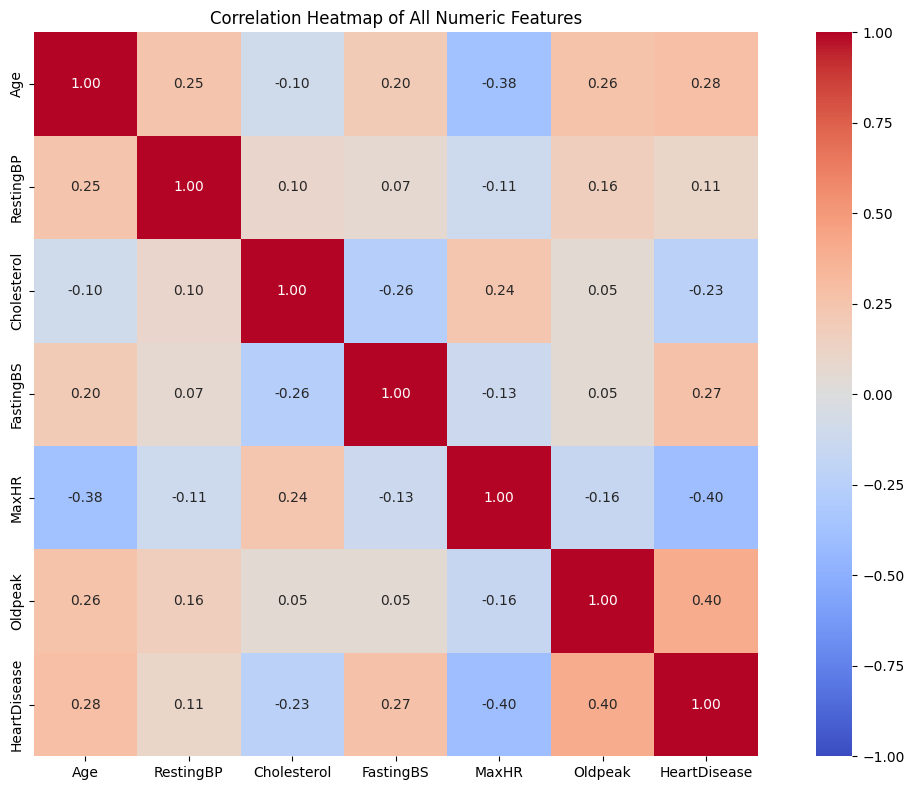

In [16]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=True,        # show the correlation values
    fmt=".2f",         # formatting for numbers
    cmap="coolwarm",   # colour palette
    vmin=-1, vmax=1,   # correlation range
    square=True
)

plt.title("Correlation Heatmap of All Numeric Features")
plt.tight_layout()
plt.show()

We are not dropping any features as all features seem to be relevant to predicting heart disease based on the EDA.

In [18]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [19]:
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [21]:
#Code adapated from MDS 571 Course 
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [22]:
numeric_transformer = StandardScaler()

In [25]:
preprocessor = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(drop='if_binary', handle_unknown="ignore", sparse_output=False), categorical_features),
)
preprocessor

,transformers,"[('standardscaler', ...), ('onehotencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [26]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)

In [27]:
X_train = train_df.drop(columns=["HeartDisease"])
X_test = test_df.drop(columns=["HeartDisease"])
y_train = train_df["HeartDisease"]
y_test = test_df["HeartDisease"]

In [28]:
classification_metrics = ["accuracy", "precision", "recall", "f1"]
# The dummy model
dc = DummyClassifier()
# The mean and std of the cross validated scores for all metrics as a dataframe
cross_val_results = {}
dummy_pipe = make_pipeline(preprocessor, dc)
cross_val_results['dummy'] = pd.DataFrame(cross_validate(dummy_pipe, X_train, y_train, cv=5, return_train_score=True, scoring = classification_metrics)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['dummy']

,mean,std
fit_time,0.004,0.002
score_time,0.005,0.002
test_accuracy,0.548,0.002
train_accuracy,0.548,0.000
test_precision,0.548,0.002
train_precision,0.548,0.000
test_recall,1.000,0.000
train_recall,1.000,0.000
test_f1,0.708,0.002
train_f1,0.708,0.000


# Discussion

# References